# Companion Notebook
This notebook contains all the code for all the experiments mentioned in the blog. 

### Import and Utility

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

THINKING_TIME = 100

In [2]:
def gen_rand_states(num_states, num_nodes):
    rng = np.random.default_rng()
    rand_states = rng.integers(low=0, high=2, size=(num_states, num_nodes))
    return rand_states


def calc_dist(state1, state2):
    return (state1!=state2).sum()

def process_results(res, memories):
    labels = []
    ghost_mems = np.logical_not(memories).astype(int)
    all_mems = np.append(memories, ghost_mems, axis=0) 
    spur_mems = np.array([], dtype=int)

    for k,v in res.items():

        if not v['is_stable']:
            continue

        for i, mem in enumerate(all_mems):
            eq = np.array_equal(v['recalled_mem'], mem)
            if eq:
                labels.append(f'mem_{i+1}')
                break
        else:
            if spur_mems.size == 0:
                spur_mems = v['recalled_mem'].reshape(1, -1)
                labels.append('spur_mem_0')
            else:
                idx_arr = np.nonzero((spur_mems==v['recalled_mem']).all(1))[0]
                if idx_arr.size != 0:
                    idx = idx_arr[0]
                    labels.append(f'spur_mem_{idx}')    
                else:
                    spur_mem_idx = spur_mems.shape[0]
                    labels.append(f'spur_mem_{spur_mem_idx}')
                    spur_mems = np.append(spur_mems, [v['recalled_mem']], axis=0)

    return labels



class HopfieldNetwork:
    def __init__(self, thinking_time, num_nodes, memories = None, show_prog = True):
        '''
        If `memories` is None then it stores random asymmetric matrix to W.
        '''
        self.results = {}
        self.stopping_step = []
        self.rng = np.random.default_rng()
        
        self.memories = memories
        self.num_nodes = num_nodes
        self.thinking_time = thinking_time
        self.show_prog = show_prog

        self.calc_mem_weights = self.calc_bin_mem_weights
        if memories is not None:
            self.W = self.fit()
        else:
            self.W = self.rng.uniform(-1, 1, size=(self.num_nodes, self.num_nodes))

    def fit(self):
        W = np.zeros((self.num_nodes, self.num_nodes))
        for mem in self.memories:
            W += self.calc_mem_weights(mem)

        return W

    def calc_bin_mem_weights(self, mem):
        x = 2*mem - 1
        mem_w = x.reshape((-1, 1))@x.reshape((1, -1))
        np.fill_diagonal(mem_w, 0)
        return mem_w

    def calc_bip_mem_weights(self, mem):
        mem_w = mem.reshape((-1, 1))@mem.reshape((1, -1))
        np.fill_diagonal(mem_w, 0)
        return mem_w
    
    def sync_remember_(self, mem):
        """
        synchronous update
        """
        mem_prev = mem.copy()
        mem_energies = [11111111]

        for t in (range(self.thinking_time)):
            local_fields = self.W@mem
            mem[local_fields>0] = 1
            mem[local_fields<0] = 0

            stop = np.equal(mem, mem_prev).all()
            if stop:
                # print('stopping at', t)
                self.stopping_step.append(t)
                break
            else:
                mem_prev = mem.copy()

        else:
            self.stopping_step.append(t)

        return mem, mem_energies
    
    def stringify_mem(self, mem):
        return ''.join(mem.astype(str))
    
    def remember_(self, mem):
        """
        async update

        `recalled_mem` contains whatever state either after loop "breaks" or "ends".
        """
        mem_prev = mem.copy()
        idxs_ = np.arange(len(mem))
        evolution = []
        is_stable = False # this stores whether `recalled_mem` is stable or not

        for t in (range(self.thinking_time)):
            self.rng.shuffle(idxs_)
            for i in idxs_:
                i_local_field = np.dot(self.W[i][:], mem)

                if i_local_field > 0:
                    mem[i] = 1
                elif i_local_field < 0:
                    mem[i] = 0


            t_data = {
                't_mem': mem.copy(),
                'mem_str': self.stringify_mem(mem),
                'energy': self.calc_energy(mem)
            }
            evolution.append(t_data)
            stop = np.equal(mem, mem_prev).all()
            if stop:
                # print('stopping at', t)
                is_stable = True
                break
            else:
                mem_prev = mem.copy()
        

        # for legacy purpose
        self.stopping_step.append(t)


        res = {
            'recalled_mem': mem,
            'evolution': evolution,
            'stopping_step': t,
            'is_stable': is_stable
        }

        return res
    

    def remember(self, mem_cues: list):
        '''
        calls `remember_` for each mem cue, fill the `results` dict and returns it.
        '''
        for i, mem_cue in tqdm(enumerate(mem_cues), total=len(mem_cues), disable= (not self.show_prog)):
            res = self.remember_(mem_cue.copy())
            res['mem_cue'] = mem_cue
            
            self.results[i] = res

        #     print('.', end='')
        # else:
        #     print()
        
        return self.results   

    def calc_energy(self, mem):
        energy = -(mem@(self.W@mem))
        return energy

    def match_memories(self, mem1, mem2):
        return (mem1==mem2).sum()/self.num_nodes

### Experiment-1
num_memory = 1

result:<br>
both memory and ghost memory states are recalled all the time but their proportion depends on the proportion of 1's, 0's in the memory. If number of 1's are greater than number of 0's in the memory then proportion of "memories" recalled is greater than "ghost memories" and vice versa.

In [12]:
num_memories = 1
num_nodes = 30
num_init_states = 1000

memories = gen_rand_states(num_memories, num_nodes)
init_states = gen_rand_states(num_init_states, num_nodes)

model = HopfieldNetwork(THINKING_TIME, num_nodes, memories)
res = model.remember(init_states)

print('Memories:')
print(memories, end='\n\n')

print('Number of 1\'s in the memory: ', (memories==1).sum(), '\n\n')

print('Some stats:')
labels = process_results(res, memories)
print(len(labels))
print(np.unique(labels, return_counts=True), end='\n\n')

print('Recalled Memories:')
for k,v in res.items():
    print(v['recalled_mem'])

100%|██████████| 1000/1000 [00:00<00:00, 3990.29it/s]


Memories:
[[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]]

Number of 1's in the memory:  15 


Some stats:
1000
(array(['mem_1', 'mem_2'], dtype='<U5'), array([486, 514], dtype=int64))

Recalled Memories:
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0]
[0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1]
[1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 

### Experiment-2
num_memory = 2

result:<br/>All init states resulted into one of 4 total memories (which includes 2 ghost memories). Again the proportion among the 4 recalled memories depends on the proportion of 1's, 0's in the respective stored memories.

When you run this cell multiple times, sometimes (rarely) it would occur that one of the init states gets evolved to a spurious memory. So, this experiment also shows how spuroious memory exists when more than 1 user memories are stored. 

In [109]:
num_memories = 2
num_nodes = 30
num_init_states = 1000

memories = gen_rand_states(num_memories, num_nodes)
init_states = gen_rand_states(num_init_states, num_nodes)

model = HopfieldNetwork(THINKING_TIME, num_nodes, memories)
res = model.remember(init_states)

print('Memories:')
print(memories, end='\n\n')

print('Some stats:')
labels = process_results(res, memories)
print(len(labels))
print(np.unique(labels, return_counts=True), end='\n\n')

print('Recalled Memories:')
for k,v in res.items():
    print(v['recalled_mem'] )

100%|██████████| 1000/1000 [00:00<00:00, 2660.06it/s]


Memories:
[[1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0]]

Some stats:
1000
(array(['mem_1', 'mem_2', 'mem_3', 'mem_4', 'spur_mem_0'], dtype='<U10'), array([231, 136, 261, 370,   2], dtype=int64))

Recalled Memories:
[0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1]
[0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1]
[1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0]
[0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1]
[0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1]
[0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1]
[1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0]
[0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1]
[1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0]
[1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0]
[0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1]
[1 1 1 1 0 1 1 1 0 1 1

In [28]:
labels = process_results(res, memories)
print(len(labels))
print(np.unique(labels, return_counts=True), end='\n\n')

1000
(array(['mem_1', 'mem_2', 'mem_3', 'mem_4', 'spur_mem'], dtype='<U8'), array([386,   3,  11, 599,   1], dtype=int64))



In [41]:
for k,v in res.items():
    pass

In [42]:
v['recalled_mem']

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1], dtype=int64)

### Experiment-3
Asymmetric W

Results: <br/>
1. Different W leads to different behaviour. Some W have stable states while others do not.
2. Didn't found a nice distribution over some small set of states where network revolves if it do not settle, rather every state is almost unique but with shorter hamming distance. (ain't this chaotic wandering around a state)

TODO: <br/>
1. need to calculate entropy
2. need to find alternating behavior, which I didn't find.


In [5]:
num_init_states = 1000
num_nodes = 30
init_states = gen_rand_states(num_init_states, num_nodes)

model = HopfieldNetwork(THINKING_TIME, num_nodes)

res = model.remember(init_states)

print('Stopping step stats:')
print(min(model.stopping_step), max(model.stopping_step))

# print('Recalled Memories:')
# for k,v in res.items():
#     print(v['recalled_mem'], v['HAHA'], )

100%|██████████| 1000/1000 [00:24<00:00, 41.60it/s]

Stopping step stats:
1 99


In [6]:
np.unique(model.stopping_step, return_counts=True)

(array([ 1, 99]), array([  1, 999], dtype=int64))

In [9]:
## this confirms that there is no nice distribution in a evolution. Max frequency is so small.
for i in range(num_init_states):
    _, counts = np.unique([d['mem_str'] for d in res[i]['evolution']], return_counts=True)
    print(counts.max(), end=', ')

3, 3, 3, 2, 4, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 2, 2, 2, 2, 4, 3, 4, 2, 3, 3, 4, 3, 3, 2, 4, 3, 2, 2, 3, 4, 2, 4, 2, 4, 3, 2, 3, 2, 3, 2, 3, 3, 4, 3, 4, 4, 3, 4, 3, 5, 2, 4, 2, 3, 2, 3, 2, 3, 2, 3, 2, 4, 2, 4, 2, 4, 2, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 5, 2, 2, 3, 3, 2, 3, 3, 3, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 4, 3, 2, 2, 2, 4, 3, 2, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2, 4, 3, 3, 3, 4, 3, 3, 5, 4, 2, 3, 4, 5, 4, 4, 3, 3, 4, 2, 3, 4, 3, 4, 4, 3, 2, 3, 2, 4, 3, 4, 3, 2, 3, 3, 2, 4, 3, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 3, 4, 3, 3, 2, 2, 3, 4, 3, 2, 3, 3, 3, 2, 2, 2, 2, 4, 5, 4, 4, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 3, 3, 3, 4, 4, 2, 3, 3, 3, 2, 3, 3, 2, 3, 5, 3, 3, 2, 2, 3, 2, 3, 5, 4, 4, 2, 2, 3, 3, 4, 4, 3, 3, 3, 3, 3, 4, 3, 4, 5, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 2, 3, 3, 3, 3, 4, 2, 2, 4, 3, 4, 2, 2, 3, 2, 3, 4, 4, 3, 3, 3, 4, 4, 2, 4, 4, 4, 4, 3, 3, 2, 4, 3, 3, 4, 3, 4, 2, 2, 2, 4, 2, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 2, 3, 3, 4, 2, 4, 3, 2, 3, 3, 3

In [29]:
'''
Analysing the hamming distances in the evolution of different init states. 
It can be seen that max hamming distance in all the evolutions is around 16-17. And the occurrence of max hamming distance is rare.
Out of (100x100-100)=4950 unique pairs, max hamming distance only occur among less than 100 pairs. When you plot the histogram of the distances (shown below), 
one will find that the distribution of the distances are bell shaped and skewed right. Having a mode around "6". 

These evidences points out to the conclusion that network evolves around similar states (having differences of only around "6") 
while rarely it gets evolved to states which are also not completely different (i.e. only gets as far as "17"). 
Also sometimes it will stumble upon the states which it visisted earlier (distance of "0").
'''

hamm_mats = []
for i in range(num_init_states):
    evol_mem = np.array([d['t_mem'] for d in res[i]['evolution']])
    hamm_mat = (evol_mem[:, None, :] != evol_mem).sum(2)
    
    
    # print(hamm_mat.min(), hamm_mat.max())
    uniq_dists, counts = np.unique(hamm_mat, return_counts=True)
    # print(uniq_dists, counts)
    # print(uniq_dists[-3:], counts[-3:])
    print(uniq_dists[np.argmax(counts)], max(counts))

    hamm_mats.append(hamm_mat)

6 1556
3 16
8 52
7 1476
6 494
6 1270
6 192
5 36
6 1530
6 78
5 574
6 552
7 784
6 1482
8 694
7 1332
7 1452
6 1480
6 1506
7 168
6 1486
5 78
5 120
6 1406
7 600
0 7
4 90
7 524
6 1052
4 20
7 30
6 1478
6 1388
6 1752
6 1478
10 90
6 1296
6 1062
7 1548
7 1396
0 5
7 624
7 158
7 1464
7 1460
7 1454
6 522
6 1404
6 1520
7 190
7 1374
5 152
6 1404
7 1526
7 1064
6 216
6 1082
6 1698
6 1436
6 318
7 88
7 22
7 510
6 1346
7 1140
7 1422
7 1534
7 860
6 1252
6 68
7 1520
7 40
6 90
6 366
7 1348
6 134
7 1402
7 1478
7 290
7 122
7 1484
6 1692
7 324
7 1426
5 700
7 940
7 1068
6 1502
6 1476
6 194
6 1392
7 106
7 60
5 1272
6 824
4 100
6 1370
6 904
6 1468
7 674
6 382
6 264
6 1514
2 54
6 1248
7 46
7 206
8 238
7 1468
6 218
7 1364
6 1250
7 1476
6 936
7 890
7 132
0 7
8 1470
7 1506
6 1412
7 1434
6 1606
7 582
5 856
8 58
6 1596
6 1300
6 1618
7 1330
6 146
5 148
7 1410
7 16
7 1524
6 1326
7 1506
7 1348
6 784
7 1432
6 1314
7 1354
8 1248
7 1454
5 64
6 1366
5 36
7 1610
7 48
6 220
4 58
5 202
7 1640
5 412
6 1464
6 1498
6 76
7 1020
7 141

(array([ 256., 1128., 2654., 1484., 2342., 1312.,  370.,  360.,   82.,
          12.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

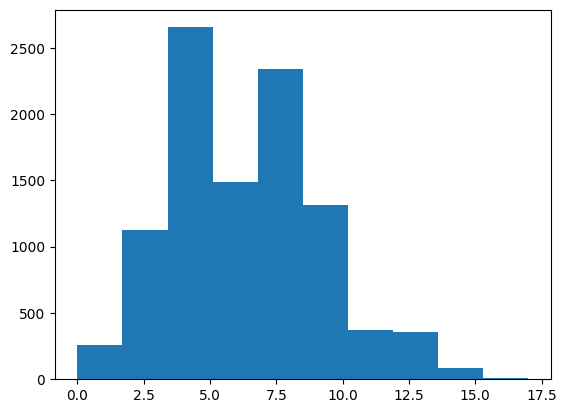

In [ ]:
# although every state is unique in the evolution but this confirms that states evolves in a small region of state space only.
plt.hist(hamm_mat.flatten())

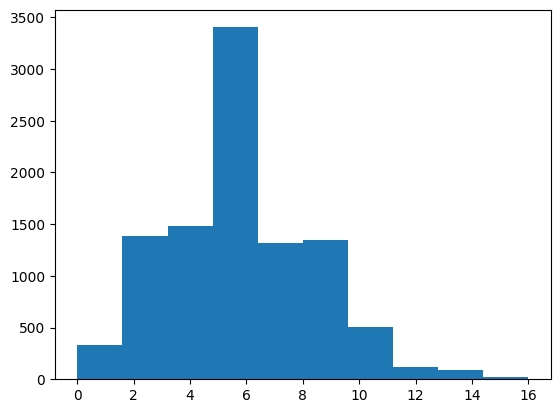

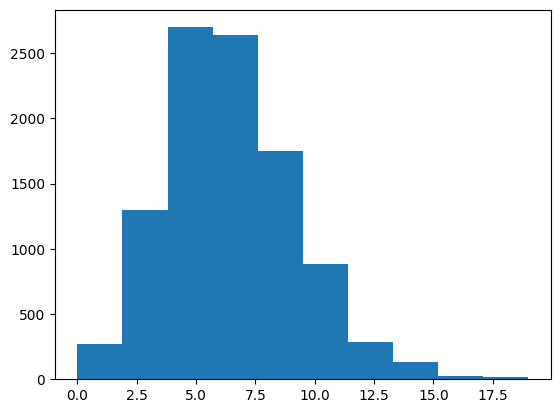

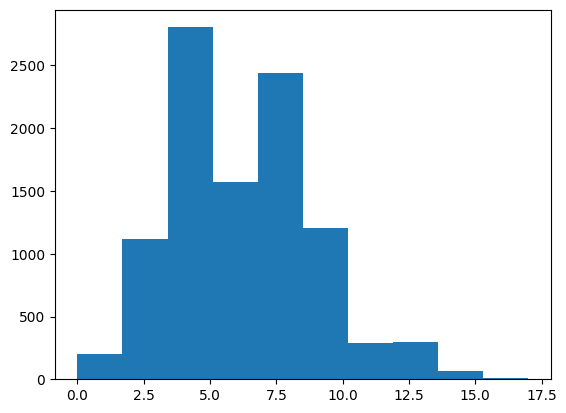

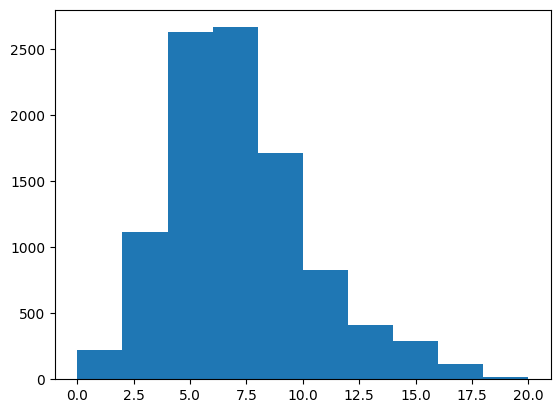

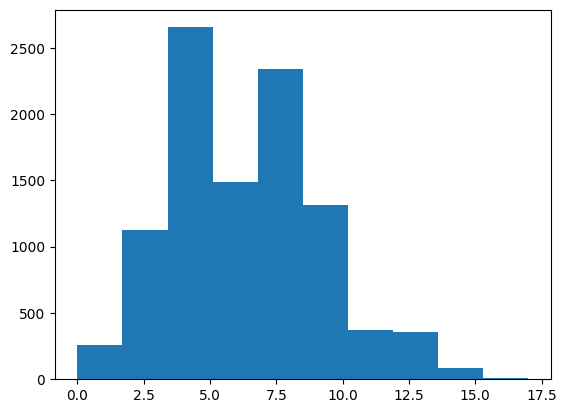

In [ ]:
# plotting some histograms
for hamm_mat in hamm_mats[:5]:
    plt.hist(hamm_mat.flatten())
    plt.show()

In [20]:
"""
This confirms that different Ws have different bahavior: some have stable states while others dont. 

"""

num_init_states = 1000
num_nodes = 30
init_states = gen_rand_states(num_init_states, num_nodes)

t = []
Ws = []
results = []

for _ in (range(5)):
    model = HopfieldNetwork(THINKING_TIME, num_nodes)
    res = model.remember(init_states)
    t.append(min(model.stopping_step))
    Ws.append(model.W)

    results.append(res)

100%|██████████| 1000/1000 [00:27<00:00, 35.75it/s]


In [21]:
np.unique(t, return_counts=True)

(array([ 1,  2, 99]), array([2, 2, 1], dtype=int64))

In [22]:
t

[2, 2, 1, 1, 99]

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0], dtype=int64)

In [37]:
r_i = 0
res = results[r_i]


is_i = 1

print(list(res.values())[is_i]['stopping_step'])
print(list(res.values())[is_i]['mem_cue'])
print(list(res.values())[is_i]['recalled_mem'])


27
[0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 1]
[0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0]


(array([163., 144., 105.,  89.,  90.,  63.,  45.,  50.,  40., 211.]),
 array([ 2. , 11.7, 21.4, 31.1, 40.8, 50.5, 60.2, 69.9, 79.6, 89.3, 99. ]),
 <BarContainer object of 10 artists>)

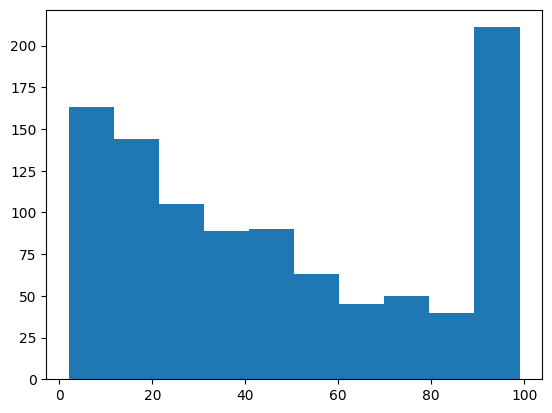

In [28]:
"""
this shows that we should try to run it for more than 100 time steps.
"""
stopping_steps = [v['stopping_step'] for v in results[0].values()]
plt.hist(stopping_steps)

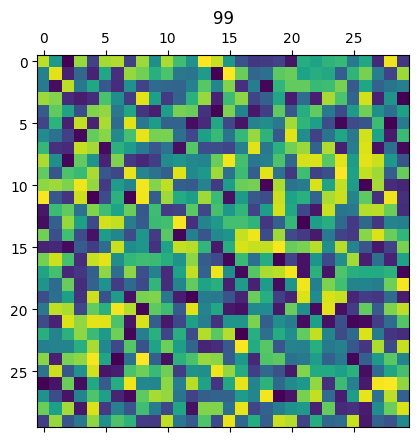

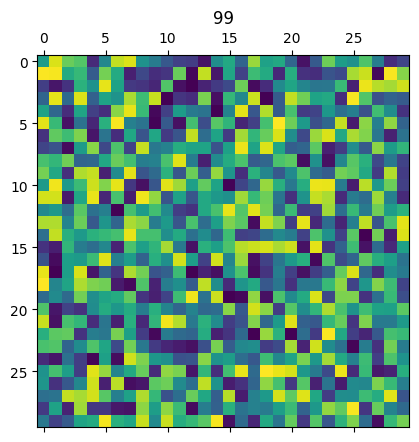

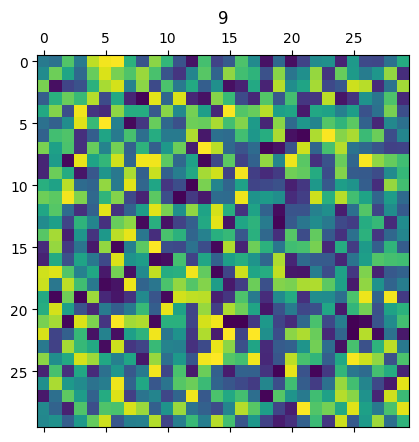

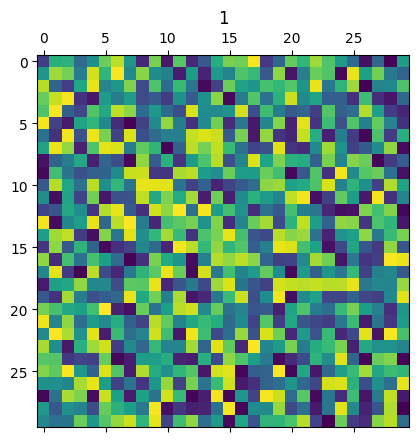

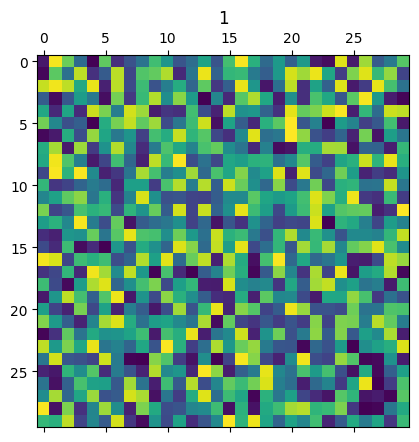

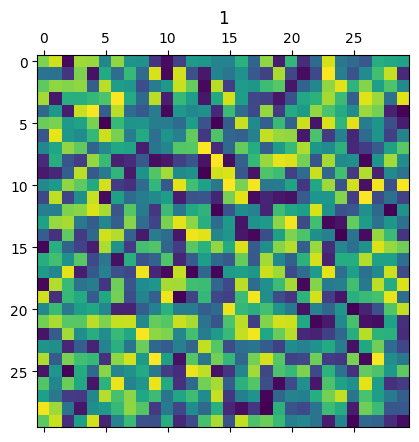

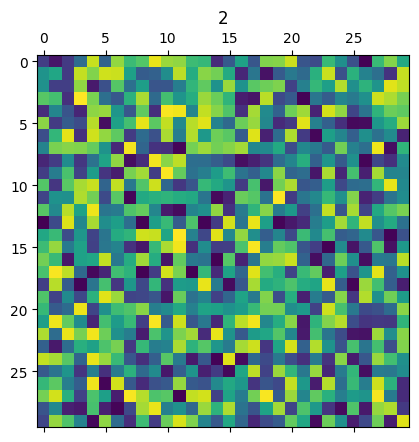

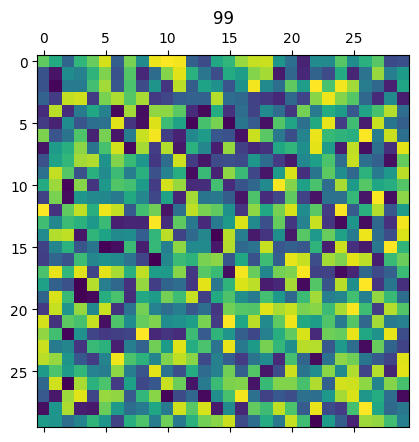

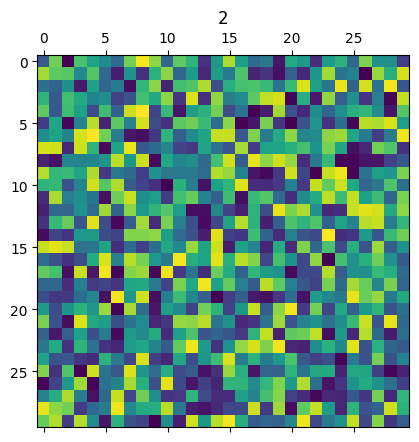

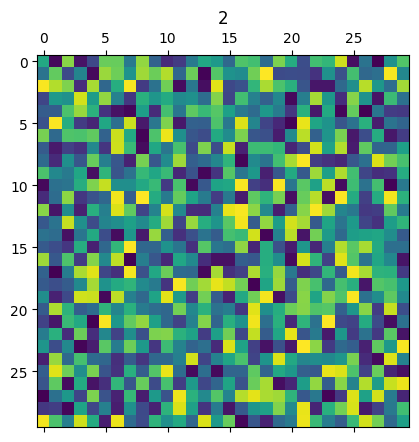

In [61]:
import matplotlib.pyplot as plt

for m, W in zip(t, Ws):
    plt.matshow(W)
    plt.title(m)
    plt.show()

### Experiment-4
Capacity Testing
Results:
1. We don’t see same result as of n=0.15N (in the paper).
2. Instead we see that result for n=0.13N
3. but that is only for N=100 and not for higher N like N=200.

TODO:
- refer McKay page-524.
- One thing I missed totally was that paper never talk about N>100. It only said about varying N=30 to 100 by scaling 'n' such that to keep P fixed. 
Then it talks about that result for n=0.15N is true for all large N. 

In [ ]:
### graphs similar to paper, but middle one varies a lot (n=10)

def process_results_exp4(res):
    proc_res = {}
    hamm_dists = []

    for k,v in res.items():
        eq = np.array_equal(v['recalled_mem'], v['mem_cue'])
        hamm_dist = (v['recalled_mem'] != v['mem_cue']).sum()
        proc_res[k] = {'is_stable': eq, 'hamm_dist': hamm_dist}

        hamm_dists.append(hamm_dist)

    return hamm_dists

num_nodes = 100
# num_init_states = 1000

for num_memories in [5, 10, 15]:
    memories = gen_rand_states(num_memories, num_nodes)
    # init_states = gen_rand_states(num_init_states, num_nodes)

    model = HopfieldNetwork(THINKING_TIME, num_nodes, memories)
    res = model.remember(memories)

    print('Some stats:')
    labels = process_results(res, memories)
    uniq_labels, uni_lab_counts = np.unique(labels, return_counts=True)
    num_mem_recalled = len([lab for lab in uniq_labels if 'spur_mem' not in lab ])
    print('num_memories : ', num_memories, 'num_memories_stable : ', num_mem_recalled)
    print(uniq_labels, uni_lab_counts, end='\n')
    print('='*30)

    # proc_res = process_results_exp4(res)
    # plt.hist(proc_res)
    # plt.show()


100%|██████████| 5/5 [00:00<00:00, 774.11it/s]


Some stats:
num_memories :  5 num_memories_stable :  5
['mem_1' 'mem_2' 'mem_3' 'mem_4' 'mem_5'] [1 1 1 1 1]


100%|██████████| 10/10 [00:00<00:00, 201.12it/s]


Some stats:
num_memories :  10 num_memories_stable :  5
['mem_4' 'mem_5' 'mem_6' 'mem_7' 'mem_9' 'spur_mem_0' 'spur_mem_1'
 'spur_mem_2' 'spur_mem_3' 'spur_mem_4'] [1 1 1 1 1 1 1 1 1 1]


100%|██████████| 15/15 [00:00<00:00, 207.52it/s]

Some stats:
num_memories :  15 num_memories_stable :  4
['mem_2' 'mem_4' 'mem_5' 'mem_7' 'spur_mem_0' 'spur_mem_1' 'spur_mem_10'
 'spur_mem_2' 'spur_mem_3' 'spur_mem_4' 'spur_mem_5' 'spur_mem_6'
 'spur_mem_7' 'spur_mem_8' 'spur_mem_9'] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [4]:
# running n=something for multiple iterations 

def calc_errors(num_nodes, num_memories, thinking_time = THINKING_TIME, reps=10, show_remember_prog=False):
    errors = []
    
    for rep in tqdm(range(reps)):
        memories = gen_rand_states(num_memories, num_nodes)
        model = HopfieldNetwork(thinking_time, num_nodes, memories, show_prog = show_remember_prog)
        res = model.remember(memories)

        for _, v in res.items():
            error = (v['recalled_mem'] != v['mem_cue']).sum()
            errors.append(error)

    return errors

100%|██████████| 10/10 [00:00<00:00, 146.77it/s]


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

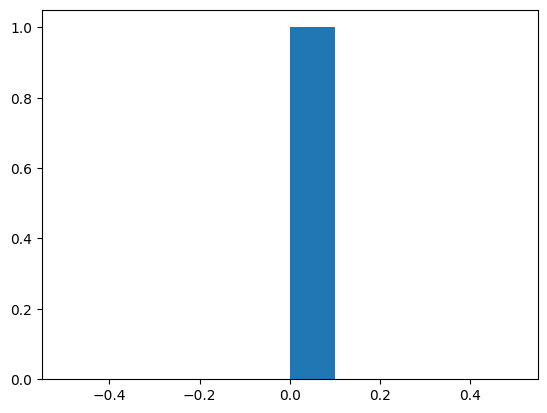

In [38]:
num_nodes = 100
num_memories = 5

errors = calc_errors(num_nodes, num_memories)

weights = np.ones_like(errors) / len(errors)
plt.hist(errors, weights=weights)
        

100%|██████████| 10/10 [00:00<00:00, 38.06it/s]


(array([0.8 , 0.01, 0.03, 0.01, 0.02, 0.03, 0.03, 0.03, 0.03, 0.01]),
 array([ 0. ,  5.5, 11. , 16.5, 22. , 27.5, 33. , 38.5, 44. , 49.5, 55. ]),
 <BarContainer object of 10 artists>)

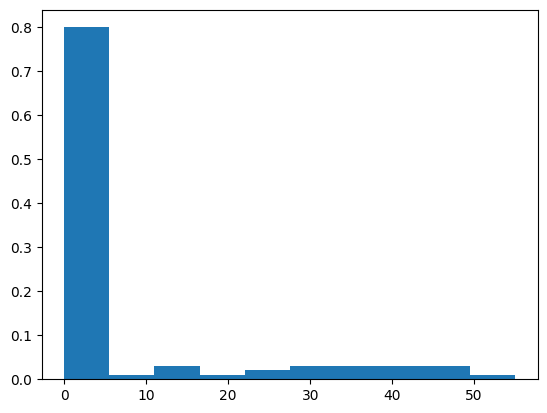

In [43]:
num_nodes = 100
num_memories = 10

errors = calc_errors(num_nodes, num_memories)

weights = np.ones_like(errors) / len(errors)
plt.hist(errors, weights=weights)
        
        

100%|██████████| 1000/1000 [01:18<00:00, 12.79it/s]


(array([0.457     , 0.05669231, 0.08253846, 0.13646154, 0.14869231,
        0.08384615, 0.02707692, 0.00623077, 0.00084615, 0.00061538]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

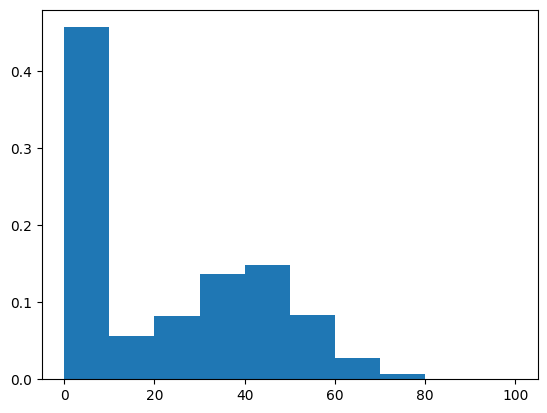

In [18]:
# Instead of 15, we are getting similar result as of the paper at n=13.

num_nodes = 100
num_memories = 13

errors = calc_errors(num_nodes, num_memories, thinking_time=1000, reps=1000)

weights = np.ones_like(errors) / len(errors)
plt.hist(errors, weights=weights)
        

100%|██████████| 10/10 [00:00<00:00, 11.76it/s]


(array([0.28571429, 0.04285714, 0.05      , 0.06428571, 0.12857143,
        0.11428571, 0.13571429, 0.08571429, 0.07857143, 0.01428571]),
 array([ 0. ,  6.8, 13.6, 20.4, 27.2, 34. , 40.8, 47.6, 54.4, 61.2, 68. ]),
 <BarContainer object of 10 artists>)

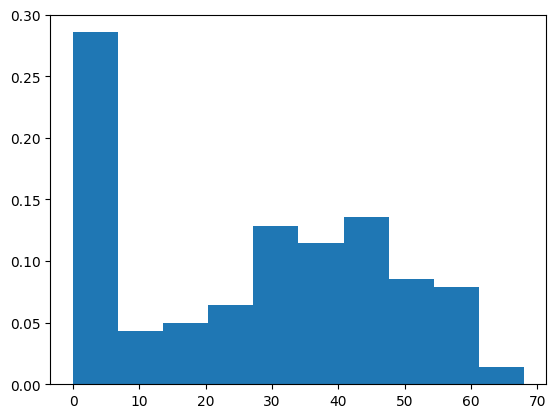

In [7]:
num_nodes = 100
num_memories = 14

errors = calc_errors(num_nodes, num_memories, thinking_time=1000, reps=10)

weights = np.ones_like(errors) / len(errors)
plt.hist(errors, weights=weights)

100%|██████████| 100/100 [00:10<00:00,  9.48it/s]


(array([0.32866667, 0.05133333, 0.08466667, 0.13533333, 0.18066667,
        0.13      , 0.06066667, 0.02266667, 0.00533333, 0.00066667]),
 array([ 0. ,  9.1, 18.2, 27.3, 36.4, 45.5, 54.6, 63.7, 72.8, 81.9, 91. ]),
 <BarContainer object of 10 artists>)

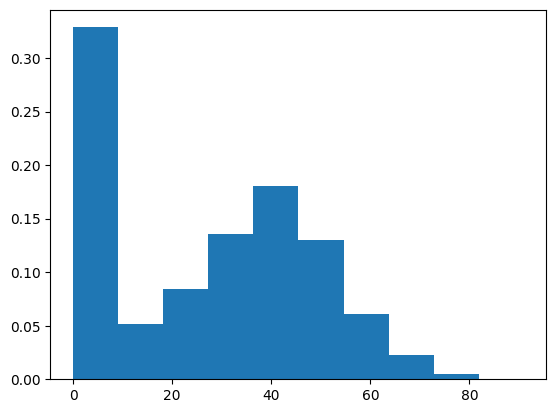

In [14]:
"""
In our case, around only 25% of the memories evolved to states with less than 5 errors, as opposed to half of the memories.
"""

num_nodes = 100
num_memories = 15

errors = calc_errors(num_nodes, num_memories, thinking_time=100000, reps=100)

weights = np.ones_like(errors) / len(errors)
plt.hist(errors, weights=weights)
        

In [15]:
uniq_errors, counts = np.unique(errors, return_counts=True)
freqs = np.array(counts)/sum(counts)

print(uniq_errors)
print(freqs)
print('----------------------------------------')
print(freqs[:5].sum())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 81 91]
[0.158      0.062      0.036      0.01933333 0.01533333 0.01266667
 0.00666667 0.00666667 0.00866667 0.00333333 0.00666667 0.00466667
 0.00333333 0.004      0.00666667 0.006      0.006      0.00866667
 0.00533333 0.00466667 0.00533333 0.00733333 0.01266667 0.01066667
 0.014      0.01       0.01133333 0.00866667 0.01466667 0.00933333
 0.00933333 0.014      0.01733333 0.01466667 0.01266667 0.022
 0.02133333 0.018      0.02666667 0.012      0.022      0.02133333
 0.018      0.02133333 0.01866667 0.02266667 0.02133333 0.01133333
 0.014      0.01933333 0.01266667 0.01066667 0.01466667 0.01333333
 0.01266667 0.01066667 0.01066667 0.00666667 0.00666667 0.008
 0.00533333 0.00666667 0.00466667 0.00133333 0.00333333 0.00466667
 0.00266667 0.002      0.004   

Num Memories: 19


100%|██████████| 1000/1000 [03:10<00:00,  5.24it/s]


(array([3.46105263e-01, 3.93684211e-02, 7.40526316e-02, 1.34684211e-01,
        1.93894737e-01, 1.42315789e-01, 5.08947368e-02, 1.56315789e-02,
        2.89473684e-03, 1.57894737e-04]),
 array([  0. ,  13.7,  27.4,  41.1,  54.8,  68.5,  82.2,  95.9, 109.6,
        123.3, 137. ]),
 <BarContainer object of 10 artists>)

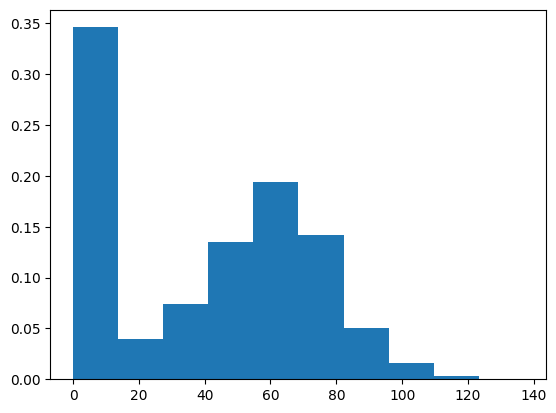

In [22]:
# The result for n=0.13N at N=100 does not seem to generalize for larger N.

num_nodes = 150
num_memories = int(0.13*num_nodes)
print(f'Num Memories: {num_memories}')

errors = calc_errors(num_nodes, num_memories, thinking_time=100000, reps=1000)

weights = np.ones_like(errors) / len(errors)
plt.hist(errors, weights=weights)

Num Memories: 30


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


(array([0.12      , 0.00666667, 0.02      , 0.07333333, 0.14333333,
        0.20666667, 0.26      , 0.13333333, 0.02666667, 0.01      ]),
 array([  0. ,  14.8,  29.6,  44.4,  59.2,  74. ,  88.8, 103.6, 118.4,
        133.2, 148. ]),
 <BarContainer object of 10 artists>)

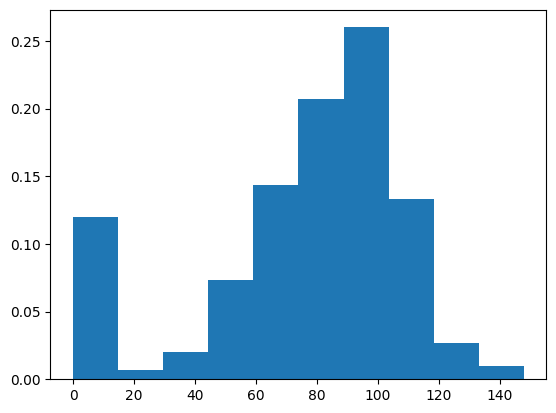

In [84]:
# Trying for larger N. And still, it is not the case.

num_nodes = 200
num_memories = int(0.15*num_nodes)
print(f'Num Memories: {num_memories}')

errors = calc_errors(num_nodes, num_memories, thinking_time=1000, reps=10)

weights = np.ones_like(errors) / len(errors)
plt.hist(errors, weights=weights)
        

Num Memories: 60


100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


(array([0.00833333, 0.003     , 0.00833333, 0.05333333, 0.196     ,
        0.377     , 0.27433333, 0.07266667, 0.00633333, 0.00066667]),
 array([  0. ,  30.8,  61.6,  92.4, 123.2, 154. , 184.8, 215.6, 246.4,
        277.2, 308. ]),
 <BarContainer object of 10 artists>)

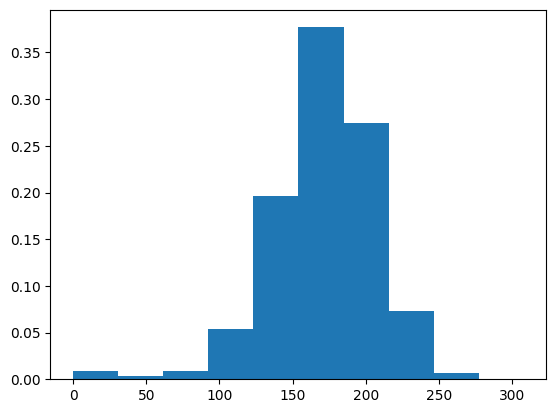

In [85]:
# Trying for larger N. 

num_nodes = 400
num_memories = int(0.15*num_nodes)
print(f'Num Memories: {num_memories}')

errors = calc_errors(num_nodes, num_memories, thinking_time=1000, reps=50)

weights = np.ones_like(errors) / len(errors)
plt.hist(errors, weights=weights)
        

### Experiment-5
Getting the idea of flow in state space

Results:<br>
1. Percentage of assigned memories depends on the W, which depends on user memories. Max it reached to around 85%. But also in one trial, it was 0%.
2. 

In [127]:
num_memories = 5
num_nodes = 30
num_init_states = 10000
reps = 30

for rep in range(reps):
    memories = gen_rand_states(num_memories, num_nodes)
    init_states = gen_rand_states(num_init_states, num_nodes)

    model = HopfieldNetwork(THINKING_TIME, num_nodes, memories, show_prog=False)
    res = model.remember(init_states)

    labels = process_results(res, memories)

    # uniq_labels, uni_lab_counts = np.unique(labels, return_counts=True)

    num_mem_recalled = len([lab for lab in labels if 'spur_mem' not in lab ])

    print(f'#{rep+1} Trials ended in assigned memories: ', num_mem_recalled/num_init_states)




#1 Trials ended in assigned memories:  0.3488
#2 Trials ended in assigned memories:  0.8395
#3 Trials ended in assigned memories:  0.7909
#4 Trials ended in assigned memories:  0.637
#5 Trials ended in assigned memories:  0.555
#6 Trials ended in assigned memories:  0.2939
#7 Trials ended in assigned memories:  0.4853
#8 Trials ended in assigned memories:  0.3215
#9 Trials ended in assigned memories:  0.0
#10 Trials ended in assigned memories:  0.5245
#11 Trials ended in assigned memories:  0.8551
#12 Trials ended in assigned memories:  0.0907
#13 Trials ended in assigned memories:  0.5479
#14 Trials ended in assigned memories:  0.4324
#15 Trials ended in assigned memories:  0.4781
#16 Trials ended in assigned memories:  0.6196
#17 Trials ended in assigned memories:  0.3213
#18 Trials ended in assigned memories:  0.7351
#19 Trials ended in assigned memories:  0.7998
#20 Trials ended in assigned memories:  0.6792
#21 Trials ended in assigned memories:  0.7558
#22 Trials ended in assigne

In [ ]:
num_memories = 5
num_nodes = 30
num_init_states = 10000
# reps = 30

memories = gen_rand_states(num_memories, num_nodes)

## For this analysis, we should also add ghost memories to the above memories array.

init_states = gen_rand_states(num_init_states, num_nodes)


dists = []
for init_state in init_states:
    init_state_dists = []
    for mem in memories:
        hamm_dist = (init_state != mem).sum()
        init_state_dists.append(hamm_dist)
    dists.append(init_state_dists)


dists = np.array(dists)
dists

array([[17, 13, 15, 14, 11],
       [13, 17, 19, 12, 21],
       [16, 16, 12, 15, 16],
       ...,
       [14, 16, 14,  9, 16],
       [14, 14, 18, 17, 14],
       [16, 12, 18, 15, 12]])

In [258]:
dists_sorted = np.sort(dists)
init_state_mask = dists_sorted[:, 0]!=dists_sorted[:, 1]


filtered_dists = dists[init_state_mask]
nearest_mem_idx = filtered_dists.argmin(axis=1)
min_dists = filtered_dists.min(axis=1)

filtered_init_states = init_states[init_state_mask]
filtered_init_states[:5]

array([[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 1],
       [1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 0]], dtype=int64)

In [274]:
model = HopfieldNetwork(THINKING_TIME, num_nodes, memories, show_prog=False)

c = 0

for init_state, mem_idx, dist in zip(filtered_init_states, nearest_mem_idx, min_dists):
    res = model.remember_(init_state.copy()) ### Using `remember_()` and not `remember()` because we have single mem cue at hand.

    print(dist)
    print('Nearest memory state: ', np.array_equal(res['recalled_mem'], memories[mem_idx]))

    c += 1

    if c==5:
        break
    

11
Nearest memory state:  False
12
Nearest memory state:  False
12
Nearest memory state:  False
12
Nearest memory state:  False
9
Nearest memory state:  False


In [140]:
np.unique(filtered_dists.min(axis=1), return_counts=True)

(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 array([   2,    9,   30,   85,  247,  608, 1160, 1705, 1746, 1297,  624,
         175,   22,    2], dtype=int64))

In [6]:
'''
Here we tackling this problem from the view of init_state. 
For a particular init_state, we run the remember_ on it for multiple times. 
And we simply calculate the frequencies of stable states it evolves to and their particular distances from it.

Here we are simply considering stable states which could be memory or ghost states.
'''

num_memories = 5
num_nodes = 30
num_init_states = 10000
reps = 100


memories = gen_rand_states(num_memories, num_nodes)
init_states = gen_rand_states(num_init_states, num_nodes)

model = HopfieldNetwork(THINKING_TIME, num_nodes, memories, show_prog=False)

100%|██████████| 10000/10000 [02:54<00:00, 57.27it/s]


[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[  158   613  2000  6608 14541 33131 53323 72512 86238 84723 63851 43390
 23704 10168  3646  1084   247    56     6     1]


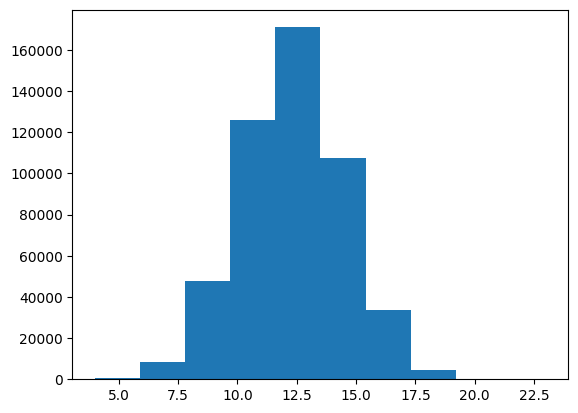

In [55]:
reps = 50

dists = []

for init_state in tqdm(init_states):
    for rep in (range(reps)):
        res_ = model.remember_(init_state.copy())
        dist = calc_dist(init_state, res_['recalled_mem'])
        dists.append(dist)

    # break

a,b = np.unique(dists, return_counts = True)
print(a)
print(b)
plt.hist(dists)
plt.show()

In [136]:
'''
So the above analysis also didn't quite worked. The hypothesis is that the random init_states in general may be quite different from 5 chosen memories, because state space is huge.
In this analysis, we are trying to create init_states by tweaking the memories as mentioned in the paper.
'''
import itertools
import math

def get_tweaked_mems(mem, idxs, r):
    idx_combs = itertools.combinations(idxs, r)

    tweaks = []
    for idx_comb in idx_combs:
        mem_copy = mem.copy()
        part = np.logical_not(mem_copy[np.array(idx_comb)])
        mem_copy[np.array(idx_comb)] = part
        
        tweaks.append(mem_copy)

    tweaks = np.array(tweaks)
    return tweaks


init_states = np.array([])
idxs = np.arange(num_nodes)

r = 1

for mem in memories:
    idx_combs = itertools.combinations(idxs, r)
    for idx_comb in tqdm(idx_combs, total=math.comb(num_nodes, r)):
        mem_tweaked = mem.copy()
        part = np.logical_not(mem_tweaked[np.array(idx_comb)])
        mem_tweaked[np.array(idx_comb)] = part
    
        if init_states.size==0:
            init_states = mem_tweaked.reshape((1, -1))
        elif not (init_states==mem_tweaked).all(1).any():
            init_states = np.append(init_states, [mem_tweaked], axis=0)



100%|██████████| 30/30 [00:00<00:00, 14988.58it/s]


100%|██████████| 150/150 [00:03<00:00, 37.52it/s]


[ 1  5  6  7  8  9 10 12 13 14 15]
[13182   315   265   296   156    21     5    37   667     6    50]


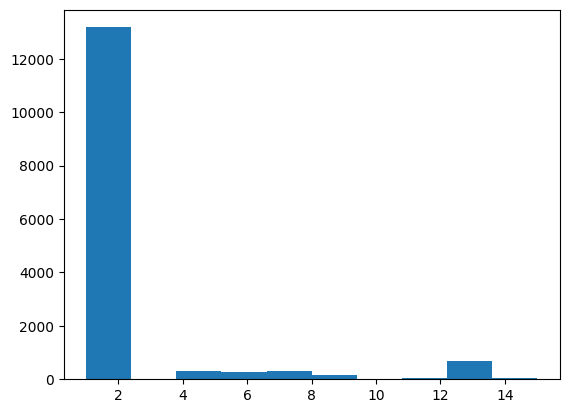

In [140]:
reps = 100
dists = []
for init_state in tqdm(init_states):
    for rep in (range(reps)):
        res_ = model.remember_(init_state.copy())
        dist = calc_dist(init_state, res_['recalled_mem'])
        dists.append(dist)

    # break

a,b = np.unique(dists, return_counts = True)
print(a)
print(b)
plt.hist(dists)
plt.show()

In [171]:
ghost_mems = np.logical_not(memories).astype(int)
all_mems = np.append(memories, ghost_mems, axis=0) 
for i, mem in enumerate(all_mems):
    print(f'mem_{i+1}: ', model.calc_energy(mem))

mem_1:  -120.0
mem_2:  -150.0
mem_3:  -148.0
mem_4:  -196.0
mem_5:  -196.0
mem_6:  -242.0
mem_7:  -212.0
mem_8:  -216.0
mem_9:  -182.0
mem_10:  -150.0


100%|██████████| 12/12 [00:00<00:00, 31.73it/s]


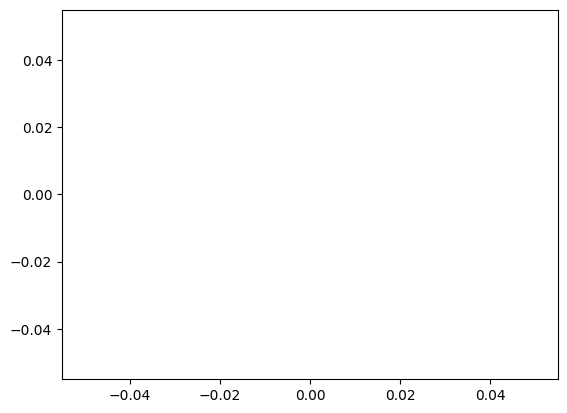

100%|██████████| 12/12 [00:00<00:00, 29.80it/s]


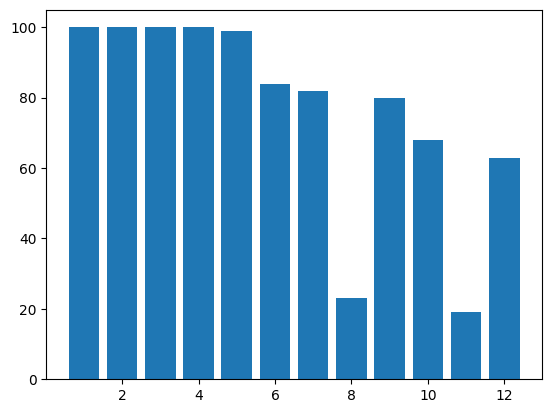

100%|██████████| 12/12 [00:00<00:00, 22.01it/s]


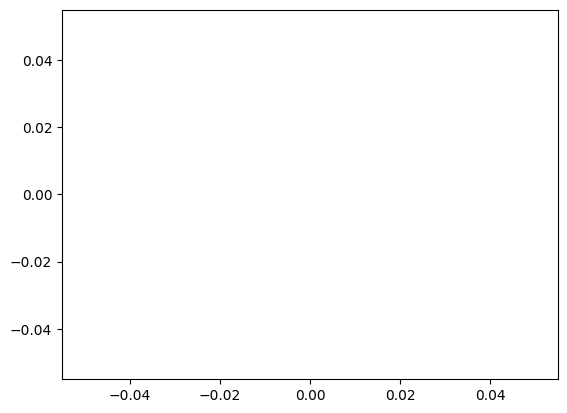

100%|██████████| 12/12 [00:00<00:00, 25.72it/s]


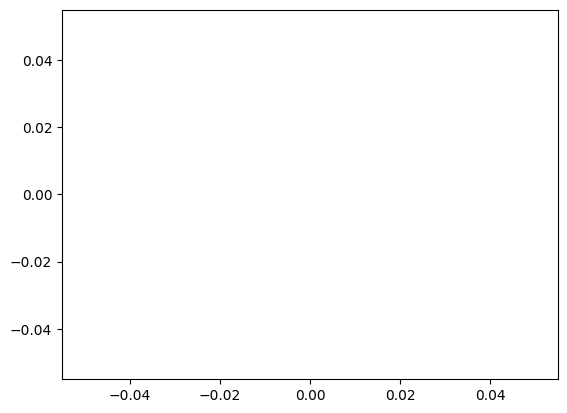

100%|██████████| 12/12 [00:00<00:00, 31.44it/s]


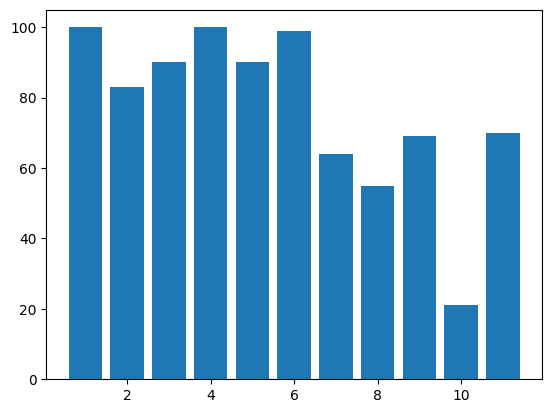

100%|██████████| 12/12 [00:00<00:00, 31.12it/s]


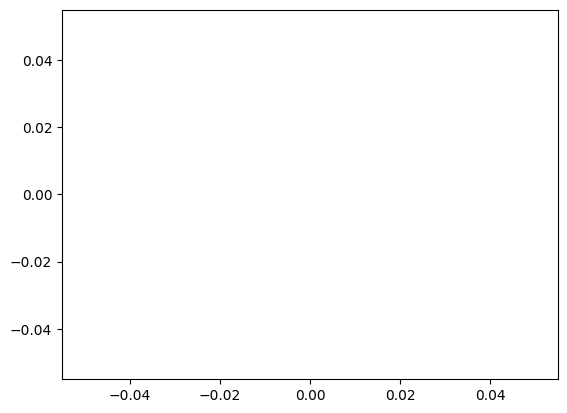

100%|██████████| 12/12 [00:00<00:00, 23.69it/s]


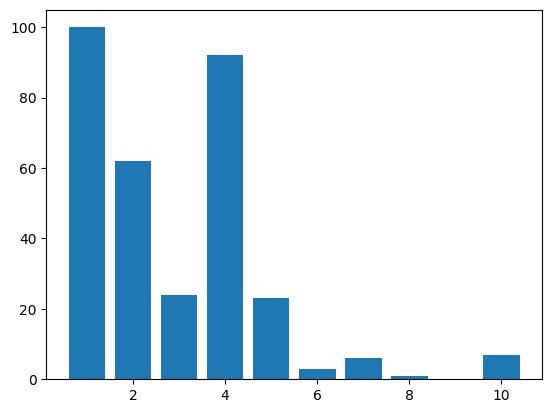

100%|██████████| 12/12 [00:00<00:00, 30.36it/s]


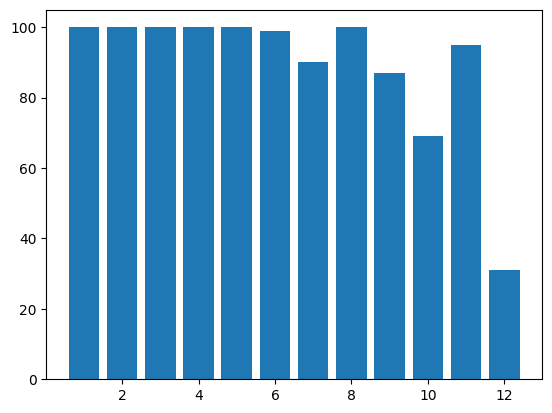

100%|██████████| 12/12 [00:00<00:00, 29.61it/s]


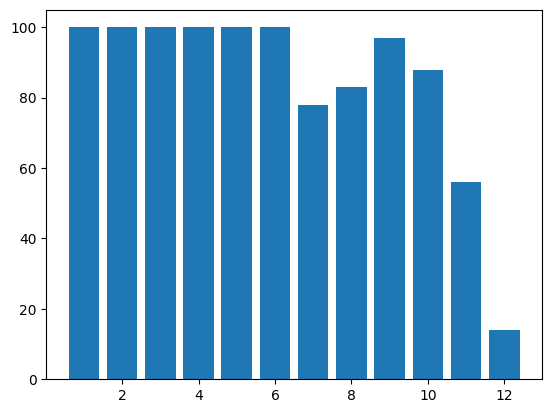

100%|██████████| 12/12 [00:00<00:00, 21.74it/s]


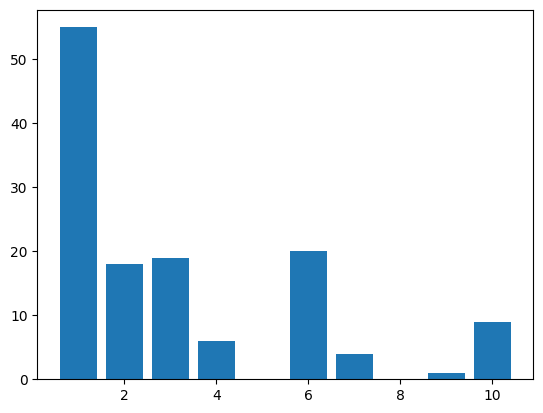

In [ ]:
'''
Now creating single tweaked mem for each dist.

Note that the empty plot is because of the unstable memories.
'''

# mem = memories[4]
ghost_mems = np.logical_not(memories).astype(int)
all_mems = np.append(memories, ghost_mems, axis=0) 

rng = np.random.default_rng()
reps = 100

for mem in all_mems:
    init_states = []
    for r in range(1, 13):   
        mem_tweaked = mem.copy()
        idx_comb = rng.choice(num_nodes, r, replace=False)
        part = np.logical_not(mem_tweaked[idx_comb])
        mem_tweaked[idx_comb] = part
        init_states.append(mem_tweaked)
    init_states = np.array(init_states)


    dists = []
    for init_state in tqdm(init_states):
        # labels = []
        for rep in range(reps):
            res = model.remember([init_state])
            if np.array_equal(res[0]['recalled_mem'], mem): ## `mem` here is chosen mem above.
                dist = calc_dist(init_state, res[0]['recalled_mem']) ## this become redundant then
                dists.append(dist)
            # labels.extend(process_results(res, memories))
        
        # a,b = np.unique(labels, return_counts=True)
        # print(a,b)

    # print('---------------')
    a,b = np.unique(dists, return_counts = True)
    # print(a)
    # print(b)
    plt.bar(a,b)
    plt.show()

In [15]:
for idx in range(10):
    x = model.remember_(all_mems[idx].copy())
    print(idx+1, np.array_equal(x['recalled_mem'], all_mems[idx]))

1 False
2 True
3 False
4 False
5 True
6 False
7 True
8 True
9 True
10 True
